# Previsão de mortes por covid com base nas doenças relatadas

O trabalho pretende predizer se uma pessoa contaminada por covid morrerá, com base em outras doenças que essa pessoa já possui.

Para fazer a previsão foram recolhidos dados de mais de 100mil pessoas. Veja abaixo a relação entre a informação(coluna) e os dados recolhidos:

In [74]:
import pandas as panda
import seaborn
import matplotlib.pyplot as plot
%matplotlib inline
import plotly.express as px
import datetime

from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error
from sklearn.model_selection import train_test_split

dados_covid_original = panda.read_csv("https://raw.githubusercontent.com/ribeiro-gabriela/regressao-linear-exercicio/main/dados-covid.csv")

dados_covid_original.head()

,USMER,MEDICAL_UNIT,SEX,PATIENT_TYPE,DATE_DIED,INTUBED,PNEUMONIA,AGE,PREGNANT,DIABETES,...,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,CLASIFFICATION_FINAL,ICU
0,2,1,1,1,03/05/2020,97,1,65,2,2,...,2,2,1,2,2,2,2,2,3,97
1,2,1,2,1,03/06/2020,97,1,72,97,2,...,2,2,1,2,2,1,1,2,5,97
2,2,1,2,2,09/06/2020,1,2,55,97,1,...,2,2,2,2,2,2,2,2,3,2
3,2,1,1,1,12/06/2020,97,2,53,2,2,...,2,2,2,2,2,2,2,2,7,97
4,2,1,2,1,21/06/2020,97,2,68,97,1,...,2,2,1,2,2,2,2,2,3,97


Levando em consideração que existem muitos dados que na minha análise não são importantes para o tipo de previsão que pretendo fazer, algumas colunas serão removidas

In [75]:
dados_covid_original.drop(columns=["USMER", "MEDICAL_UNIT", "PATIENT_TYPE", "INTUBED", "CLASIFFICATION_FINAL", "ICU"], axis=1, inplace=True)

dados_covid_original.head()

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,03/05/2020,1,65,2,2,2,2,2,1,2,2,2,2,2
1,2,03/06/2020,1,72,97,2,2,2,2,1,2,2,1,1,2
2,2,09/06/2020,2,55,97,1,2,2,2,2,2,2,2,2,2
3,1,12/06/2020,2,53,2,2,2,2,2,2,2,2,2,2,2
4,2,21/06/2020,2,68,97,1,2,2,2,1,2,2,2,2,2


Podemos analisar a distribuição das idades dos pacientes na base de dados

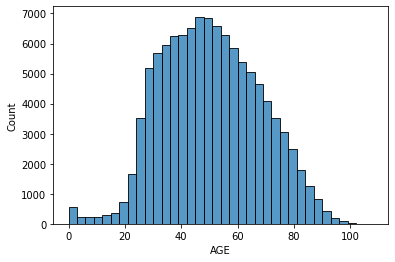

In [76]:
seaborn.histplot(data=dados_covid_original['AGE'], binwidth=3);

In [77]:
dados_covid_original.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 108987 entries, 0 to 108986
Data columns (total 15 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   SEX             108987 non-null  int64 
 1   DATE_DIED       108987 non-null  object
 2   PNEUMONIA       108987 non-null  int64 
 3   AGE             108987 non-null  int64 
 4   PREGNANT        108987 non-null  int64 
 5   DIABETES        108987 non-null  int64 
 6   COPD            108987 non-null  int64 
 7   ASTHMA          108987 non-null  int64 
 8   INMSUPR         108987 non-null  int64 
 9   HIPERTENSION    108987 non-null  int64 
 10  OTHER_DISEASE   108987 non-null  int64 
 11  CARDIOVASCULAR  108987 non-null  int64 
 12  OBESITY         108987 non-null  int64 
 13  RENAL_CHRONIC   108987 non-null  int64 
 14  TOBACCO         108987 non-null  int64 
dtypes: int64(14), object(1)
memory usage: 12.5+ MB


Nesse momento eu quero entender se o paciente morreu ou não, sabendo que as datas inválidas mostram pacientes sem data de morte (não morreram)

In [79]:
dados_covid_original['DATA_FORMATADA']=panda.to_datetime(dados_covid_original['DATE_DIED'][dados_covid_original['DATE_DIED']!="9999-99-99"], format="%d/%m/%Y")

In [80]:
dados_covid_original.tail()

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DATA_FORMATADA
108982,1,9999-99-99,2,52,2,2,2,2,2,2,2,2,2,2,2,NaT
108983,2,9999-99-99,2,42,97,2,2,2,2,2,2,2,2,2,2,NaT
108984,1,9999-99-99,1,42,2,2,2,2,2,2,2,2,1,2,2,NaT
108985,2,9999-99-99,2,48,97,2,2,2,2,2,1,2,2,2,2,NaT
108986,1,9999-99-99,2,36,2,2,2,2,2,2,2,2,1,2,2,NaT


In [81]:
dados_covid_original['DATE_DIED'].value_counts()

9999-99-99    67580
07/07/2020      552
16/06/2020      541
06/07/2020      537
13/07/2020      536
              ...  
20/10/2020        1
18/10/2020        1
16/10/2020        1
14/10/2020        1
12/10/2020        1
Name: DATE_DIED, Length: 337, dtype: int64

In [82]:
dados_covid_original['MORREU'] = [2 if each == "9999-99-99" else 1 for each in dados_covid_original['DATE_DIED'] ] # 2 esta vivo / 1 esta morto

Veja abaixo a contagem entre vivos (número 2) e mortos (número 1) 

In [83]:
dados_covid_original['MORREU'].value_counts()

2    67580
1    41407
Name: MORREU, dtype: int64

Podemos explorar também os meses e a relação com a quantidade de mortes, primeiramente criando uma coluna para os meses

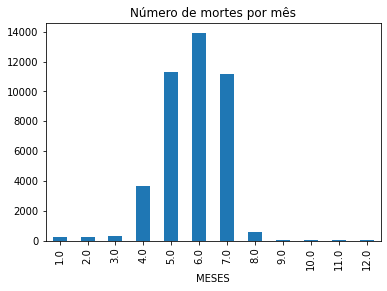

In [84]:
dados_covid_original['MESES']=dados_covid_original["DATA_FORMATADA"].dt.month

dados_covid_original.groupby("MESES")["MORREU"].count().plot(kind="bar");
plot.title("Número de mortes por mês");

In [85]:
dados_covid_original['VELHO'] = [2 if each < 60 else 1 for each in dados_covid_original['AGE']] # 1 a pessoa e velha / 2 a pessoa e nova

In [86]:
dados_covid_original.head()

,SEX,DATE_DIED,PNEUMONIA,AGE,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO,DATA_FORMATADA,MORREU,MESES,VELHO
0,1,03/05/2020,1,65,2,2,2,2,2,1,2,2,2,2,2,2020-05-03,1,5.0,1
1,2,03/06/2020,1,72,97,2,2,2,2,1,2,2,1,1,2,2020-06-03,1,6.0,1
2,2,09/06/2020,2,55,97,1,2,2,2,2,2,2,2,2,2,2020-06-09,1,6.0,2
3,1,12/06/2020,2,53,2,2,2,2,2,2,2,2,2,2,2,2020-06-12,1,6.0,2
4,2,21/06/2020,2,68,97,1,2,2,2,1,2,2,2,2,2,2020-06-21,1,6.0,1


In [87]:
def porcent_morreu(nome_coluna,tinha=1, morreu=1):
    total=dados_covid_original[dados_covid_original[nome_coluna]==tinha].AGE.count()
    num_mortos=dados_covid_original[(dados_covid_original[nome_coluna]==tinha) & (dados_covid_original['MORREU']==morreu)].AGE.count()
    return num_mortos/total*100
                


porcentagem = []
colunas=["PREGNANT", "ASTHMA","HIPERTENSION", "VELHO", "OBESITY", "CARDIOVASCULAR", "RENAL_CHRONIC", "TOBACCO", "OTHER_DISEASE", "COPD", "DIABETES", "PNEUMONIA"]
for i in colunas:
    p = porcent_morreu(i)
    print("Porcentagem de pacientes que morreram com {} é: {}%".format(i, "%.2f"%p))
    porcentagem.append(p)
print("Porcentagem máxima de mortes: {}".format("%.2f"% max(porcentagem)))  


Porcentagem de pacientes que morreram com PREGNANT é: 5.78%
Porcentagem de pacientes que morreram com ASTHMA é: 26.03%
Porcentagem de pacientes que morreram com HIPERTENSION é: 60.90%
Porcentagem de pacientes que morreram com VELHO é: 74.23%
Porcentagem de pacientes que morreram com OBESITY é: 41.71%
Porcentagem de pacientes que morreram com CARDIOVASCULAR é: 66.62%
Porcentagem de pacientes que morreram com RENAL_CHRONIC é: 75.42%
Porcentagem de pacientes que morreram com TOBACCO é: 42.10%
Porcentagem de pacientes que morreram com OTHER_DISEASE é: 52.80%
Porcentagem de pacientes que morreram com COPD é: 74.32%
Porcentagem de pacientes que morreram com DIABETES é: 63.55%
Porcentagem de pacientes que morreram com PNEUMONIA é: 69.27%
Porcentagem máxima de mortes: 75.42


In [88]:
px.bar(x=colunas, y=porcentagem, text_auto=".2s", title="Porcentagem de mortos por cada doença:")


# Predizendo se uma pessoa morrerá ou não com determinada doença ao se contaminar por covid

Para "aprender" se um paciente morrerá ou não por ter determinada(s) doença(s) precisamos definir quais são os aspectos que se relacionam com o resultado (doença vs morrer ou não morrer)

In [89]:
dados_covid_original.columns

Index(['SEX', 'DATE_DIED', 'PNEUMONIA', 'AGE', 'PREGNANT', 'DIABETES', 'COPD',
       'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR',
       'OBESITY', 'RENAL_CHRONIC', 'TOBACCO', 'DATA_FORMATADA', 'MORREU',
       'MESES', 'VELHO'],
      dtype='object')

Com as características definidas, agora eu devo separar os vivos dos mortos

In [90]:
features=['PNEUMONIA', 'PREGNANT', 'DIABETES', 'COPD', 'ASTHMA', 'INMSUPR', 'HIPERTENSION', 'OTHER_DISEASE', 'CARDIOVASCULAR', 'OBESITY', 'RENAL_CHRONIC', 'TOBACCO']

# separando os dados

y = dados_covid_original.MORREU.iloc[:-10]
x= dados_covid_original.loc[:,features].iloc[:-10]
novos_dados= dados_covid_original.loc[:, features].iloc[-10:]
resultado_novos_dados=dados_covid_original['MORREU'].iloc[-10:]
x.head()

,PNEUMONIA,PREGNANT,DIABETES,COPD,ASTHMA,INMSUPR,HIPERTENSION,OTHER_DISEASE,CARDIOVASCULAR,OBESITY,RENAL_CHRONIC,TOBACCO
0,1,2,2,2,2,2,1,2,2,2,2,2
1,1,97,2,2,2,2,1,2,2,1,1,2
2,2,97,1,2,2,2,2,2,2,2,2,2
3,2,2,2,2,2,2,2,2,2,2,2,2
4,2,97,1,2,2,2,1,2,2,2,2,2


A partir de agora eu vou separar parte dos dados para treinamento, e outra parte como dados reais (por padrão 75% treino, 25% reais)

In [91]:
from imblearn.over_sampling import RandomOverSampler
from sklearn.model_selection import train_test_split
ros = RandomOverSampler(random_state=0)
x_re,y_re = ros.fit_resample(x,y)

treino_x, valores_x, treino_y, valores_y = train_test_split(x_re, y_re, random_state=1) 

In [92]:
# Criando modelo de decisão
model = DecisionTreeRegressor(random_state=1)
model.fit(treino_x, treino_y)
prediction = model.predict(valores_x)
prediction

array([1.73988982, 1.26193204, 1.08      , ..., 1.31666667, 1.24551832,
       1.7188418 ])

In [93]:


# Criando tabelas para comparar a predição com os dados reais
real_pred={"Real":list(valores_y[10:20]),
          "Predict": list(prediction[10:20])}
df_real_pred=panda.DataFrame(real_pred)
df_real_pred

,Real,Predict
0,2,1.620321
1,2,1.877646
2,1,1.127339
3,1,1.245518
4,1,1.620321
5,1,1.261932
6,2,1.936479
7,2,1.877646
8,2,1.877646
9,2,1.500000


In [94]:
# Comparação entre os dados preditos e os dados reais %%
mae = mean_absolute_error(prediction, valores_y)

In [98]:
print("% de validação do modelo: {:,f}".format(mae))

% de validação do modelo: 0.342196


In [96]:
# Teste do modelo
list(model.predict(novos_dados))

[1.8776464118779215,
 1.8663366336633664,
 1.1777777777777778,
 1.7188417960553923,
 1.7398898209590585,
 1.8776464118779215,
 1.7398898209590585,
 1.3486590038314177,
 1.5742574257425743,
 1.8663366336633664]

In [97]:
# check real values 
resultado_novos_dados


108977    2
108978    2
108979    2
108980    2
108981    2
108982    2
108983    2
108984    2
108985    2
108986    2
Name: MORREU, dtype: int64

Por fim, o modelo previu quais pacientes irão sobreviver.